# DeepCrack Crack Segmentation with U-Net + VGG16 Encoder

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# PARAMETERS
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 2

# PATHS
BASE_PATH = "C:\\Users\\Administrator\\Downloads\\DeepCrack"
TRAIN_IMG_DIR = "C:\\Users\\Administrator\\Downloads\\DeepCrack\\train_img"
TRAIN_MASK_DIR = "C:\\Users\\Administrator\\Downloads\\DeepCrack\\train_lab"
TEST_IMG_DIR = "C:\\Users\\Administrator\\Downloads\\DeepCrack\\test_img"
TEST_MASK_DIR = "C:\\Users\\Administrator\\Downloads\\DeepCrack\\test_lab"

PRED_OUTPUT_DIR = "C:\\Users\]Administrator]\Downloads\\DeepCrack\\Output\\Pred_output"
OVERLAY_OUTPUT_DIR = "C:\\Users\\Administrator\\Downloads\\DeepCrack\\Output\\Overlay_output"
CSV_OUTPUT_PATH = "C:\\Users\\Administrator\\Downloads\\DeepCrack\\Output\\Csv_output.csv"

In [ ]:
# AUGMENTATION

def augment(image, mask):
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    if np.random.rand() > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
    return image, mask

In [ ]:
def load_images(img_dir, mask_dir, augment_flag=False):
    images, masks = [], []
    for fname in sorted(os.listdir(img_dir)):
        img_path = os.path.join(img_dir, fname)
        mask_name = fname.replace(".jpg", ".png")  # ✅ Match .jpg to .png
        mask_path = os.path.join(mask_dir, mask_name)

        if not os.path.exists(img_path) or not os.path.exists(mask_path):
            print(f"⚠️ Missing file: {fname}, skipping...")
            continue

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            print(f"⚠️ Could not load: {fname}, skipping...")
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        mask = (mask > 127).astype(np.uint8)

        if augment_flag:
            img, mask = augment(img, mask)

        images.append(img)
        masks.append(np.expand_dims(mask, axis=-1))

    return np.array(images), np.array(masks)


✅ Train size: (300, 256, 256, 3)
✅ Val size: (237, 256, 256, 3)


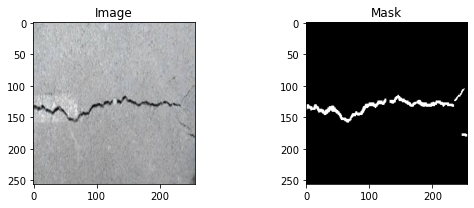

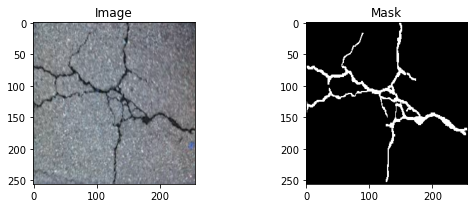

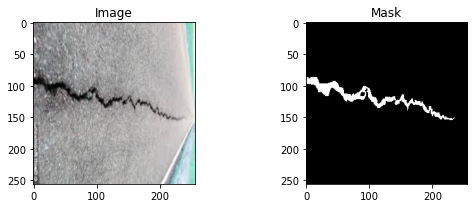

In [ ]:
# QUICK PREVIEW UTILITY

def preview_data(x, y, n=3):
    for i in range(n):
        plt.figure(figsize=(8, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(x[i])
        plt.title("Image")
        plt.subplot(1, 2, 2)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title("Mask")
        plt.tight_layout()
        plt.show()

x_train, y_train = load_images(TRAIN_IMG_DIR, TRAIN_MASK_DIR, augment_flag=True)
x_val, y_val = load_images(TEST_IMG_DIR, TEST_MASK_DIR)

print("✅ Train size:", x_train.shape)
print("✅ Val size:", x_val.shape)

if x_train.shape[0] > 0 and y_train.shape[0] > 0:
    preview_data(x_train, y_train)

In [ ]:
# METRICS

def dice_coefficient(y_true, y_pred):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-7)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [ ]:
# BUILD U-NET WITH VGG16 ENCODER

def build_unet_vgg(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg.trainable = False

    skips = [
        vgg.get_layer("block1_conv2").output,
        vgg.get_layer("block2_conv2").output,
        vgg.get_layer("block3_conv3").output,
        vgg.get_layer("block4_conv3").output
    ]
    b = vgg.get_layer("block5_conv3").output
    encoder = keras.Model(inputs=vgg.input, outputs=[*skips, b])

    inputs = keras.Input(shape=input_shape)
    s1, s2, s3, s4, b = encoder(inputs)

    u4 = layers.UpSampling2D()(b)
    u4 = layers.Concatenate()([u4, s4])
    c4 = layers.Conv2D(512, 3, padding='same')(u4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Conv2D(512, 3, padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)

    u3 = layers.UpSampling2D()(c4)
    u3 = layers.Concatenate()([u3, s3])
    c3 = layers.Conv2D(256, 3, padding='same')(u3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Conv2D(256, 3, padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)

    u2 = layers.UpSampling2D()(c3)
    u2 = layers.Concatenate()([u2, s2])
    c2 = layers.Conv2D(128, 3, padding='same')(u2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Conv2D(128, 3, padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)

    u1 = layers.UpSampling2D()(c2)
    u1 = layers.Concatenate()([u1, s1])
    c1 = layers.Conv2D(64, 3, padding='same')(u1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Conv2D(64, 3, padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c1)
    return keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# COMPILE & TRAIN
model = build_unet_vgg()
model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', dice_coefficient])
model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
    keras.callbacks.ModelCheckpoint("deepcrack_vgg16_unet.h5", save_best_only=True)
]

if x_train.shape[0] > 0:
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks
    )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 256, 256, 6  14714688    ['input_2[0][0]']                
                                4),                                                               
                                 (None, 128, 128, 1                                               
                                28),                                                              
                                 (None, 64, 64, 256                                         

Epoch 1/2
38/38 [==============================] - 445s 12s/step - loss: 0.6921 - accuracy: 0.9275 - dice_coefficient: 0.3106 - val_loss: 0.6324 - val_accuracy: 0.8848 - val_dice_coefficient: 0.3706 - lr: 0.0010
Epoch 2/2
38/38 [==============================] - 438s 12s/step - loss: 0.4208 - accuracy: 0.9861 - dice_coefficient: 0.5810 - val_loss: 0.6318 - val_accuracy: 0.9478 - val_dice_coefficient: 0.3704 - lr: 0.0010


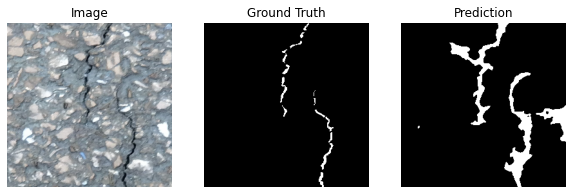

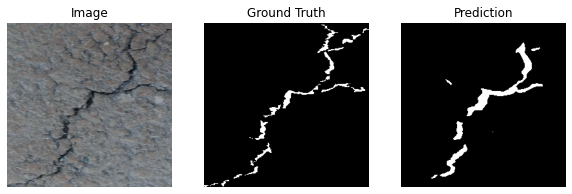

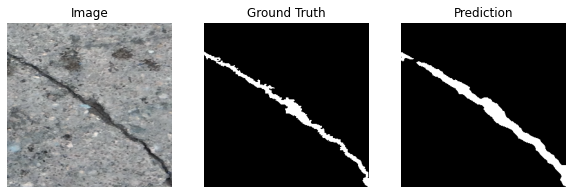

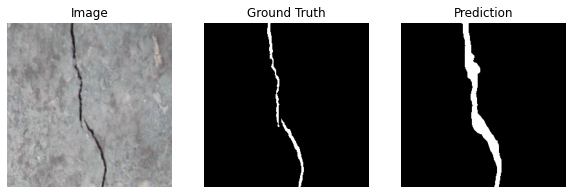

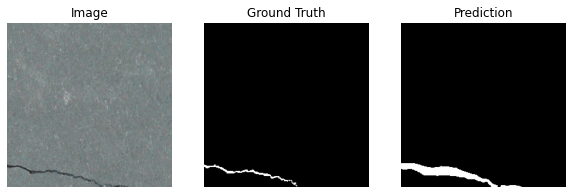

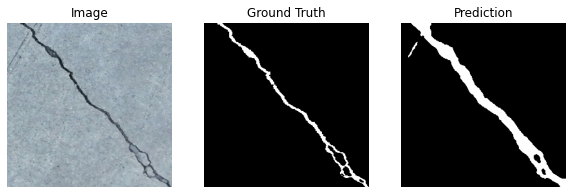

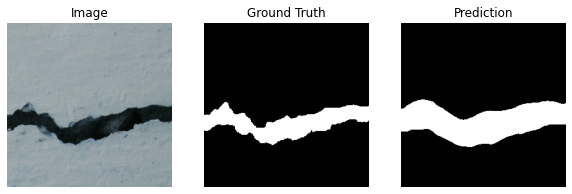

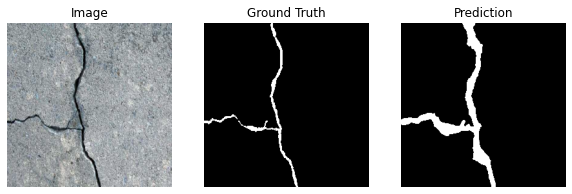

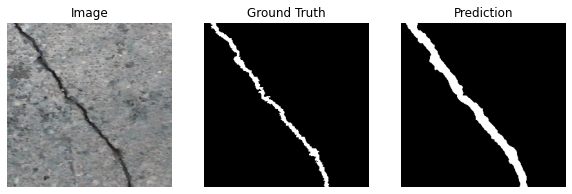

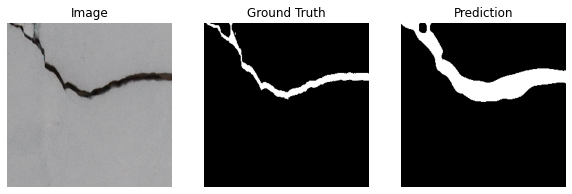

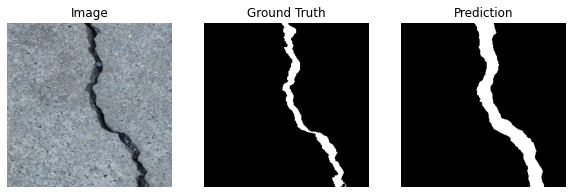

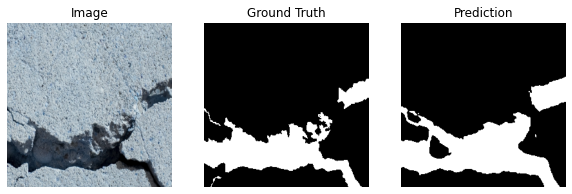

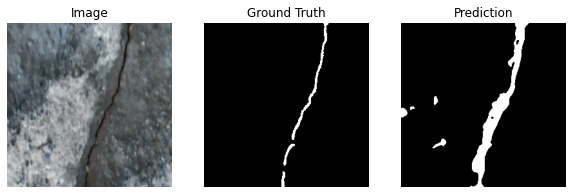

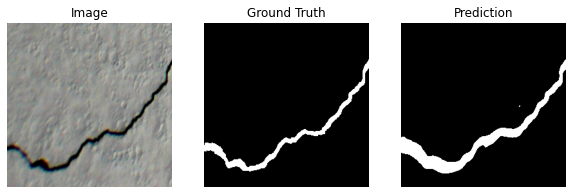

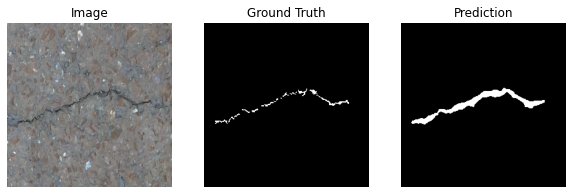

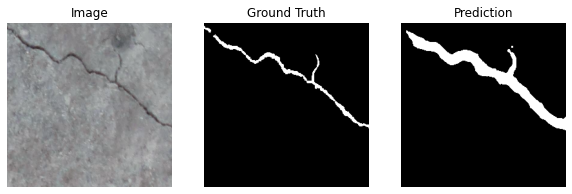

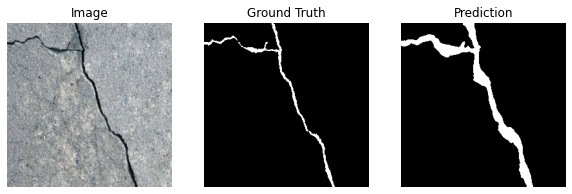

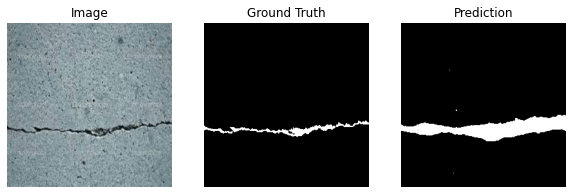

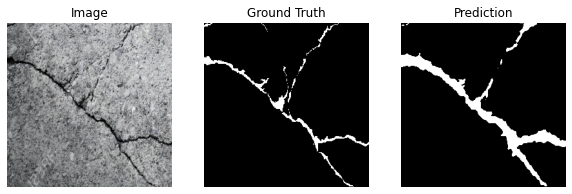

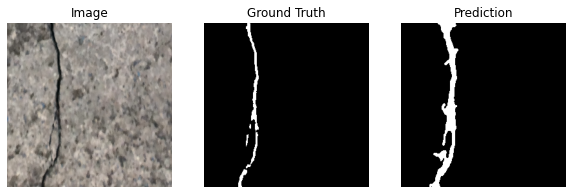

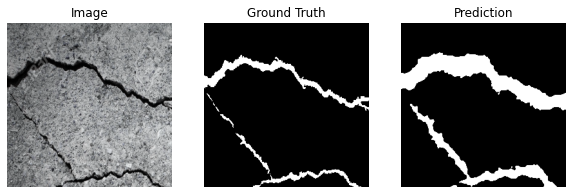

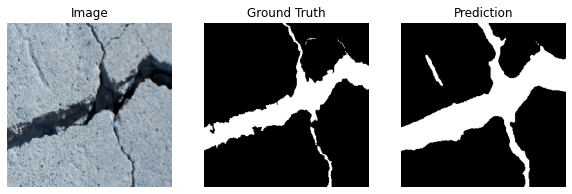

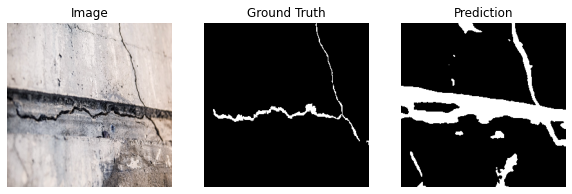

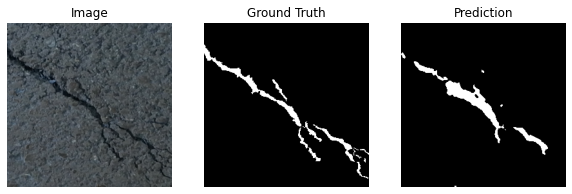

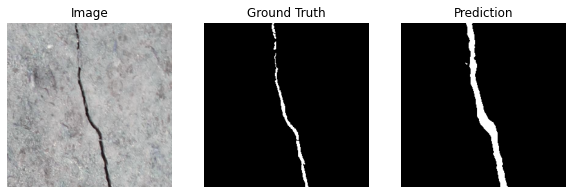

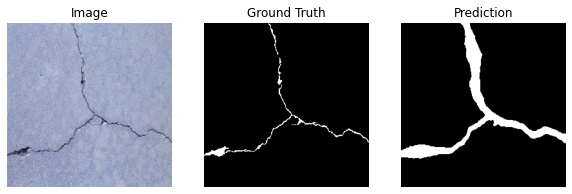

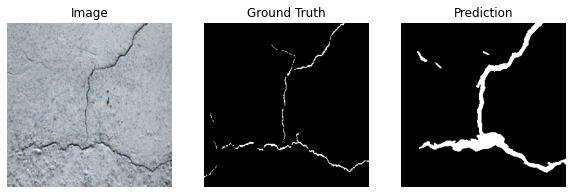

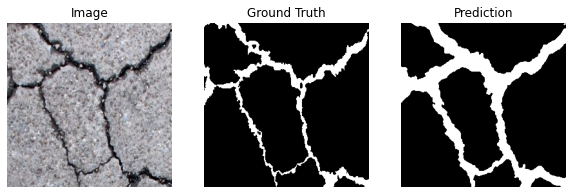

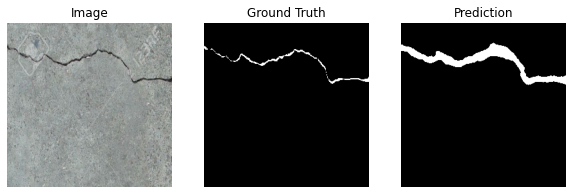

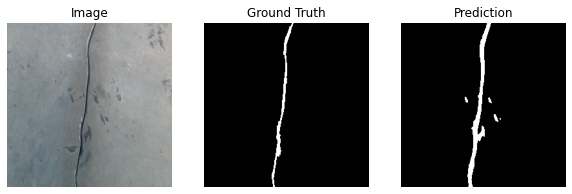

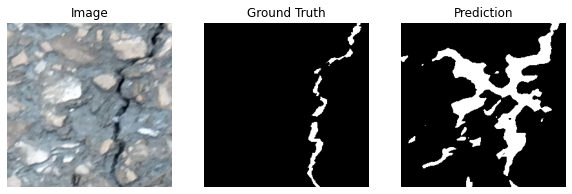

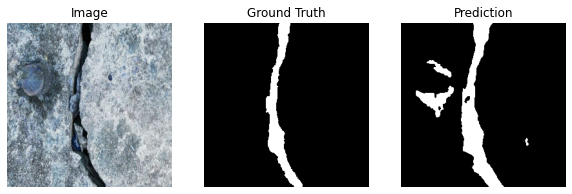

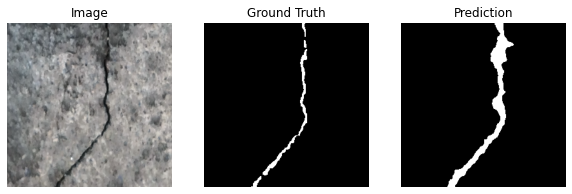

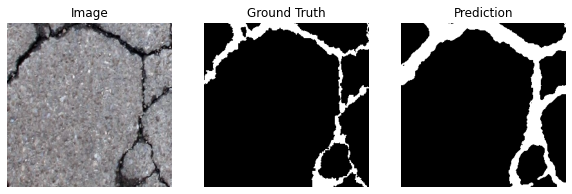

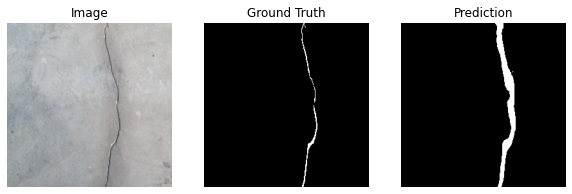

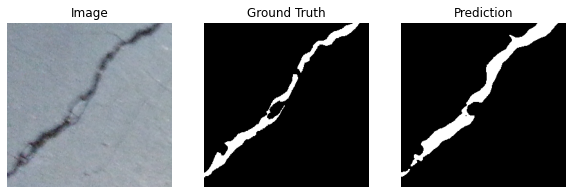

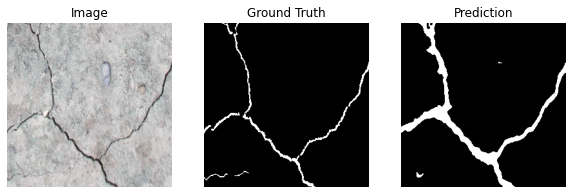

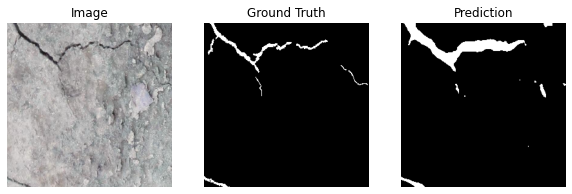

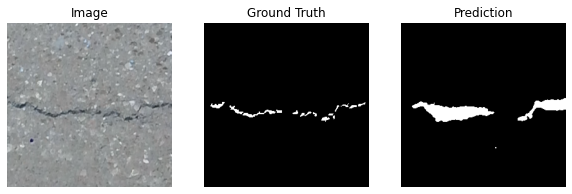

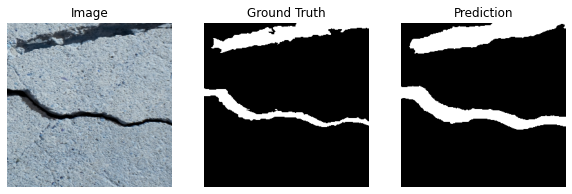

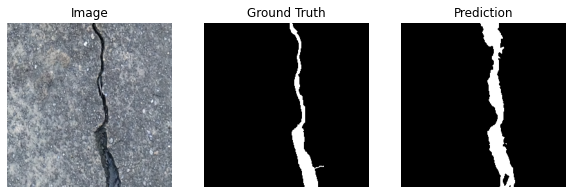

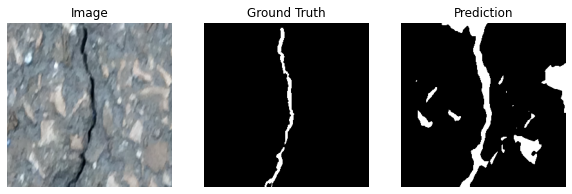

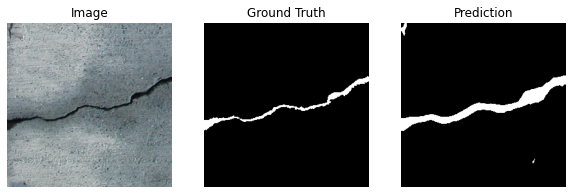

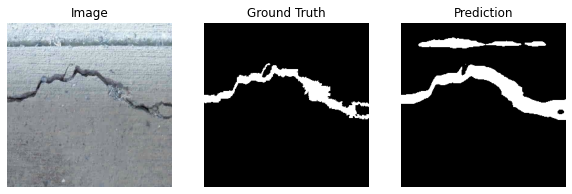

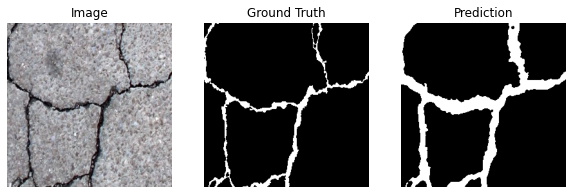

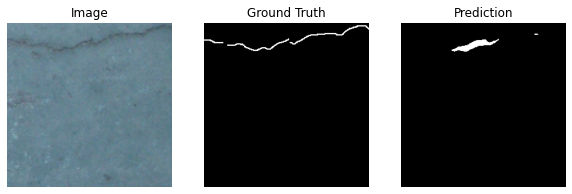

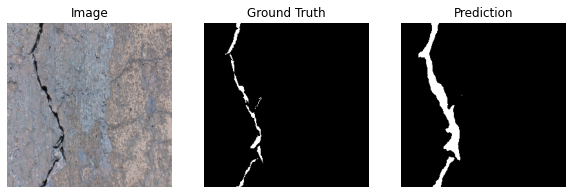

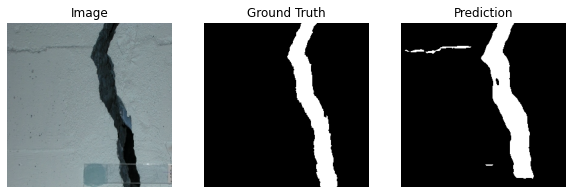

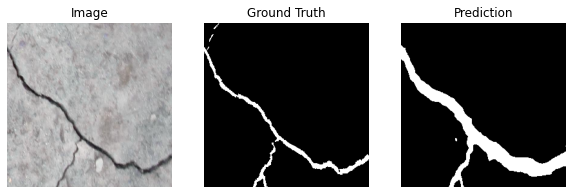

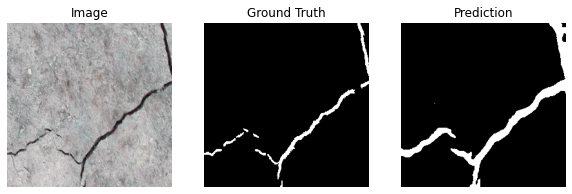

In [ ]:
# VISUALIZE, SAVE, OVERLAY & LOG PREDICTIONS

def visualize_and_save_predictions(n=50):
    if x_val.shape[0] == 0:
        print("⚠️ No validation data loaded.")
        return

    os.makedirs(PRED_OUTPUT_DIR, exist_ok=True)
    os.makedirs(OVERLAY_OUTPUT_DIR, exist_ok=True)
    summary_data = []

    indices = np.random.choice(len(x_val), n, replace=False)
    preds = model.predict(x_val[indices])

    for i in range(n):
        pred_mask = (preds[i].squeeze() > 0.5).astype(np.uint8) * 255
        image = (x_val[indices[i]] * 255).astype(np.uint8)
        gt_mask = (y_val[indices[i]].squeeze() * 255).astype(np.uint8)

        # Save predicted mask
        pred_filename = os.path.join(PRED_OUTPUT_DIR, f"pred_{i}.png")
        cv2.imwrite(pred_filename, pred_mask)

        # Save overlay
        overlay = image.copy()
        overlay[pred_mask == 255] = [0, 0, 255]
        overlay_filename = os.path.join(OVERLAY_OUTPUT_DIR, f"overlay_{i}.png")
        cv2.imwrite(overlay_filename, overlay)

        # Calculate cracked pixel stats
        cracked_pixels = int(np.sum(pred_mask > 0))
        total_pixels = pred_mask.shape[0] * pred_mask.shape[1]
        crack_percent = (cracked_pixels / total_pixels) * 100

        # Classify condition
        if crack_percent > 20:
            action = "⚠️ Immediate Repair Needed"
        elif crack_percent > 5:
            action = "🛠️ Monitor - Not Urgent"
        else:
            action = "✅ No Repair Needed"

        # Log results
        summary_data.append({
            "Image_Index": i,
            "Cracked_Pixels": cracked_pixels,
            "Crack_%": round(crack_percent, 2),
            "Action_Recommended": action
        })

        # Visualization
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

        plt.show()

    # Save summary as CSV
    pd.DataFrame(summary_data).to_csv(
        "C:\\Users\\Administrator\\Downloads\\DeepCrack\\Output\\prediction_summary.csv",
        index=False
    )

# Call the function
visualize_and_save_predictions()